### libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

### secondary functions

In [2]:
def rho_kgm3(T):
    # T , K
    # rho = 999.972, kg/m3   T=277 K
    denominator = 1 + (T-273)/10000*(0.269*(T-273)**0.637 - 0.8)
    return 1000/denominator

def V_ms(Q_liq, d_in):
    # Q_liq , m3/day 
    # d_in, mm 
    return Q_liq/86400 / np.pi*4 / (d_in/1000)**2
    
def visc_MPa(P, T):
    # P , MPa
    # T , K  
    A = 109.574
    B = 1.1217
    return A*(1.8*T - 460)**(-B) * (0.9994 + 0.0058*P + 0.6534 * 10**(-4) * P**2)
    
def Re(rho_m, v_m, d_in,  mu_m):
    # rho_m , kg/m3
    # v_m , m/s 
    # d_in , mm
    # mu_m , MPa s
    return rho_m*v_m*(d_in/1000) /  (mu_m / 10**6)

def friction_factor_Moody(Re, eps, d_in):
    # eps, m
    # d_in , mm
    f = 1/( 1.14 - 2 * np.log10(eps*1000/d_in + 21.25/Re**0.9) )**2 
    return 64/Re if Re < 3000 else f  




### pressure gradient

In [3]:
def Dp_Dx(x):
    cos_alpha = cos[0] if x <= MD[1] else cos[1] 
    T = T_wh + (T_wf-T_wh)/TVD[-1] * x * cos_alpha if x <= MD[1] else T_wh + (T_wf-T_wh)/TVD[-1] * ( (x-MD[1])*cos_alpha + TVD[1])
    rho = rho_kgm3(T)
    mu = visc_MPa(P[-1]/10**6, T)  
    re = Re(rho, v, d, mu)
    f = friction_factor_Moody(re, eps, d)
    dp_dx = rho * 9.8 * cos_alpha - f * rho * v**2 / (2*d/1000)
    return dp_dx

### main pressure calculation 

In [4]:
eps = 7.2 * 10**(-5) # m
H = 2416 # m
d = 124 # mm
Q = 21 # m3/day
P_wh =  15.9 * 101325 # Pa
T_wh = 23.5 + 273 # °K
T_wf = T_wh+50    # °K

MD = [0, 1208, 2416]
TVD = [0, 1146, 2044]

# Calculation
P = []
P.append(P_wh)
h_md = np.linspace(0, H, 100)

v = V_ms(Q, d)
cos = [(TVD[i+1] - TVD[i]) / (MD[i+1] - MD[i]) for i in range(len(MD)-1)]

for i in range(0,99):
    P_next =  P[-1] + quad(Dp_Dx, h_md[i] , h_md[i+1])[0]
    P.append(P_next)

In [5]:
### траектория скважины

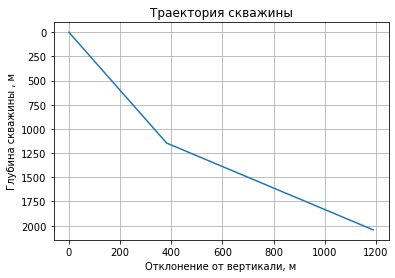

In [6]:
import math
delta = []
delta.append(0)
for i in range(len(MD)-1):
    delta.append( delta[-1] + (MD[i+1] - MD[i]) *math.sin( math.acos(cos[i]) ) )

plt.plot(delta, TVD)
plt.grid()
ax = plt.gca()
ax.invert_yaxis()
plt.xlabel("Отклонение от вертикали, м")
plt.ylabel("Глубина скважины , м")
plt.title("Траектория скважины")
plt.show()

### распределение давления в скважине

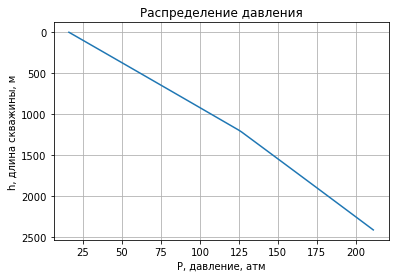

In [7]:
P_atma = [i/101325 for i in P]
plt.plot(P_atma, h_md)
plt.grid()
ax = plt.gca()
ax.invert_yaxis()
plt.ylabel("h, длина скважины, м")
plt.title("Распределение давления");
plt.xlabel("P, давление, атм")
plt.show()

### кривая зависимости забойного давления от дебита в диапазоне дебитов от 10 до 500 м3/сут

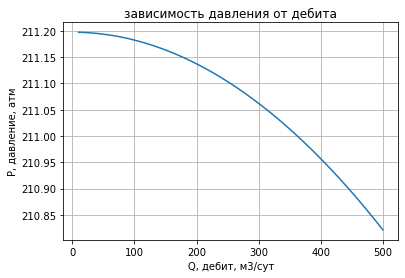

In [8]:
Q_10_to_500 = np.linspace(10,500,246) # m3/day

eps = 7.2 * 10**(-5) # m
H = 2416 # m
d = 124 # mm
P_wh =  15.9 * 101325 # Pa
T_wh = 23.5 + 273 # °K
T_wf = T_wh+50    # °K

MD = [0, 1208, 2416]
TVD = [0, 1146, 2044]

P_wf_q = []
for q in Q_10_to_500:
    Q = q # m3/day
    
    # Calculation
    P = []
    P.append(P_wh)
    h_md = np.linspace(0, H, 100)

    v = V_ms(Q, d)
    cos = [(TVD[i+1] - TVD[i]) / (MD[i+1] - MD[i]) for i in range(len(MD)-1)]

    for i in range(0,99):
        P_next =  P[-1] + quad(Dp_Dx, h_md[i] , h_md[i+1])[0]
        P.append(P_next)
    
    P_wf_q.append(P[-1]/101325)
    
plt.plot(Q_10_to_500, P_wf_q)
plt.grid()
plt.xlabel("Q, дебит, м3/сут")
plt.title("зависимость давления от дебита");
plt.ylabel("P, давление, атм")
plt.show()

### кривая зависимости забойоного давления от температуры в диапазоне T_0 от 10 до 50 градусов Цельсия

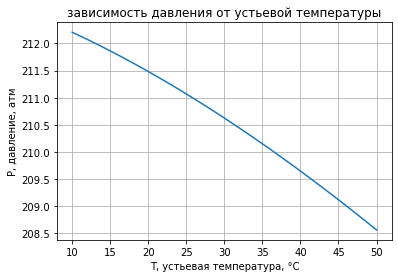

In [9]:
T_10_to_50 = np.linspace(10,50,41)

eps = 7.2 * 10**(-5) # m
H = 2416 # m
d = 124 # mm
Q = 21 # m3/day
P_wh =  15.9 * 101325 # Pa

MD = [0, 1208, 2416]
TVD = [0, 1146, 2044]

P_wf_t = []
for t in T_10_to_50:   
    T_wh = t + 273 # °K
    T_wf = T_wh+50    # °K

    # Calculation
    P = []
    P.append(P_wh)
    h_md = np.linspace(0, H, 100)

    v = V_ms(Q, d)
    cos = [(TVD[i+1] - TVD[i]) / (MD[i+1] - MD[i]) for i in range(len(MD)-1)]

    for i in range(0,99):
        P_next =  P[-1] + quad(Dp_Dx, h_md[i] , h_md[i+1])[0]
        P.append(P_next)
        
    P_wf_t.append(P[-1]/101325)
    
plt.plot(T_10_to_50, P_wf_t)
plt.grid()
plt.xlabel("T, устьевая температура, °С")
plt.title("зависимость давления от устьевой температуры");
plt.ylabel("P, давление, атм")
plt.show()

### to json file

In [10]:
import json

In [11]:
to_json_file = {
        'ex1' : {'h' : h_md.tolist(), 'p' : P_atma} , 
        'ex2' : {'q_liq' : Q_10_to_500.tolist(), 'p_wf' : P_wf_q} , 
        'ex3' : {'t' : T_10_to_50.tolist() , 'p_wf' : P_wf_t} 
       }
# test
with open('answer.json', 'w') as f:
    json.dump(to_json_file, f)